The initial calculation of the the adjusted ratings was done with the following SQLite.

``` mysql
WITH updates(ID, newvalue) AS (
    SELECT user_ratings.userratingID,
        (user_ratings.userrating * spi.opp_spi)/100
    FROM user_ratings
    INNER JOIN spi ON user_ratings.gameID = spi.gameID
)
UPDATE user_ratings SET adj_userrating = 
    (
    SELECT newvalue
    FROM updates
    WHERE user_ratings.userratingID = ID
    )
;
```
Many thanks to [MikeT on StackOverflow](https://stackoverflow.com/questions/49745150/sqlite-multiply-columns-to-update-a-third-column) for helping me figure this out.

In [19]:
import arserate as arse
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db_path = '../db_files/ratings.db'

In [3]:
df = arse.ready_df(db_path=db_path)

This notebook investigates the dataset with a new metric The SPI data only goes back a couple of years, so some of our data isn't relevant.

In [4]:
spi_df = df[df['adj_userrating']>0]
spi_df.head()

,playerID,gameID,date,season,competition,home_away,opponent,arsegoals,oppgoals,wld,...,adj_userrating,name,number,positions,natl_team,birthdate,academy_grad,nickname,rare_positions,url
133,3,134.0,2016-08-20,2016-17,Premier League,away,Leicester City,0.0,0.0,draw,...,5.68905,Laurent Koscielny,6,CB,France,1985-09-10,False,,,http://news.arseblog.com/2016/08/leicester-0-0...
134,3,135.0,2016-08-27,2016-17,Premier League,away,Watford,3.0,1.0,win,...,4.72240,Laurent Koscielny,6,CB,France,1985-09-10,False,,,http://news.arseblog.com/2016/08/watford-1-3-a...
135,3,136.0,2016-09-10,2016-17,Premier League,home,Southampton,2.0,1.0,win,...,6.10020,Laurent Koscielny,6,CB,France,1985-09-10,False,,,http://news.arseblog.com/2016/09/arsenal-2-1-s...
136,3,137.0,2016-09-13,2016-17,Champions League,away,PSG,1.0,1.0,draw,...,4.65575,Laurent Koscielny,6,CB,France,1985-09-10,False,,,http://news.arseblog.com/2016/09/psg-1-1-arsen...
137,3,138.0,2016-09-17,2016-17,Premier League,away,Hull City,4.0,1.0,win,...,3.76600,Laurent Koscielny,6,CB,France,1985-09-10,False,,,http://news.arseblog.com/2016/09/hull-1-4-arse...


In [5]:
def season_apps_min(df, season, min_apps):
    """Limit dataset to players who made some minimum number of appearances in a given season
    
    Parameters
    ----------
    df : pandas DataFrame
        DataFrame with each row corresponding to a player appearance
    season : {'all', 2013-14', '2014-15', '2015-16', '2016-17', '2017-18'}
        Season of interest or 'all' seasons
    
    Returns
    -------
    apps_df : pandas DataFrame
        A dataframe of summary data by player
    """
    if season == 'all':
        df_season = df
    else:
        df_season = df[df['season']==season]
    
    season_summary = arse.quick_summary(df_season, by='player')
    apps_df = season_summary.loc[season_summary['appearances']['size']>=min_apps]
    return apps_df

In [6]:
def top11_chart(players_df, rating_type='userrating', title=''):
    apps_avg = players_df[(rating_type,'mean')].mean()
    print(apps_avg)
    top11_df = players_df.sort_values([(rating_type,'mean')], ascending=False).iloc[0:11]
    
    sns.set_style('whitegrid')
    sns.set_context("talk") # 'paper', 'notebook', 'talk', 'poster'
    plot = sns.barplot(x=(rating_type,'mean'), y=top11_df.index, data=top11_df, color='#EC0C1C')

    # clean up the plot
    plot.axes.yaxis.set_tick_params(width=0)
    plot.set_xlabel('')
    plot.set_ylabel('Player (appearances)')
    plot.set_xticks(range(0,11))
    
    ylab = top11_df.index.map(str)+" ("+top11_df['appearances', 'size'].map(str)+")"
    plot.set_yticklabels(ylab)
    plot.set_xlim(left=0.0, right=10.0)
    plot.set_title(title)

    # add data labels to the bars
    for p in plot.patches:
        width = p.get_width()
        plot.text(x=p.get_width()+0.25,
                  y=p.get_y()+p.get_height()/2,
                  s='{0:.2f}'.format(width),
                  va='center',
                  fontsize=14
                 )
    
    # add vertical line at mean of all players after accounting for the appearance minimum
    plot.axvline(x=apps_avg, ls='dashed', c='lightgray', lw=2)
    sns.despine(left=True, bottom=True)
    return plot

In [7]:
summary_df = arse.quick_summary(spi_df, by='player')
apps_df = summary_df.loc[summary_df['appearances']['size']>=20]
adj_top_df = apps_df.sort_values([('adj_userrating','mean')], ascending=False)
adj_top_df

appearances userrating                   \
                               size       mean median  min  max   
name                                                              
Petr Cech                        64   6.640625    7.0  2.0  9.0   
Alexandre Lacazette              26   6.500000    7.0  3.0  8.5   
Laurent Koscielny                66   6.318182    7.0  2.0  9.0   
Nacho Monreal                    64   6.359375    6.5  2.0  9.0   
Mesut Özil                       68   6.352941    7.0  2.0  9.5   
Jack Wilshere                    29   6.500000    6.5  3.5  9.0   
Alexis Sanchez                   64   6.187500    6.5  2.0  9.5   
Sead Kolasinac                   26   6.192308    6.5  3.0  9.0   
Hector Bellerin                  70   5.964286    6.0  1.5  9.0   
Granit Xhaka                     70   5.878571    6.0  1.5  8.5   
Shkodran Mustafi                 58   5.905172    6.5  2.0  9.5   
Gabriel Paulista                 20   5.825000    6.5  2.0  8.0   
Mohamed Elneny                   37   6.297297    6.5  4.0  8.5   
Aaron Ramsey                     45   5.800000    6.5  1.5  9.0   
Rob Holding                      24   6.145833    6.5  2.5  8.5   
Olivier Giroud                   55   5.736364    6.0  2.0  9.0   
Francis Coquelin                 45   5.600000    6.0  1.5  8.5   
Alex Oxlade-Chamberlain          37   5.567568    6.0  1.0  8.0   
Alex Iwobi                       52   5.413462    5.5  2.0  8.5   
Danny Welbeck                    41   5.073171    5.5  2.0  8.5   
Theo Walcott                     41   5.012195    5.0  2.0  9.0   

                        adj_userrating                             \
                                  mean    median      min     max   
name                                                                
Petr Cech                     4.288559  4.188450  1.00840  7.1655   
Alexandre Lacazette           4.204350  3.890800  1.51260  7.1655   
Laurent Koscielny             4.159425  4.194875  1.09640  7.5870   
Nacho Monreal                 4.125155  3.978125  1.53060  7.1655   
Mesut Özil                    4.085559  4.156375  1.47575  7.5870   
Jack Wilshere                 4.020228  3.810800  1.75000  6.8272   
Alexis Sanchez                3.998241  3.976675  1.47575  7.2990   
Sead Kolasinac                3.924762  3.884075  1.64460  6.6704   
Hector Bellerin               3.877625  3.809100  1.14795  7.2990   
Granit Xhaka                  3.856045  3.782550  1.00840  6.8935   
Shkodran Mustafi              3.786727  3.856900  1.09640  8.0085   
Gabriel Paulista              3.777647  3.840625  1.70610  5.5094   
Mohamed Elneny                3.776273  3.702000  2.25000  5.4030   
Aaron Ramsey                  3.739473  3.823950  1.13740  7.0873   
Rob Holding                   3.708308  3.531200  1.75000  6.1365   
Olivier Giroud                3.645422  3.631200  1.42175  6.8000   
Francis Coquelin              3.640036  3.794250  1.38615  6.4880   
Alex Oxlade-Chamberlain       3.607680  3.702000  0.76530  6.1365   
Alex Iwobi                    3.463130  3.184350  1.09640  6.8935   
Danny Welbeck                 3.304829  3.377600  1.09640  6.1365   
Theo Walcott                  3.225630  2.999500  1.11120  7.2990   

                        arseblograting                    
                                  mean median  min   max  
name                                                      
Petr Cech                     6.788413  7.000  3.0  10.0  
Alexandre Lacazette           6.822083  7.000  4.0   8.0  
Laurent Koscielny             6.369063  7.000  2.0   9.0  
Nacho Monreal                 6.411587  6.500  2.0   9.0  
Mesut Özil                    6.429924  7.000  0.0   9.5  
Jack Wilshere                 6.519259  6.500  4.0   9.0  
Alexis Sanchez                6.380952  6.500  2.0  10.0  
Sead Kolasinac                6.102000  6.000  0.0   9.0  
Hector Bellerin               6.283788  6.115  2.0   8.0  
Granit Xhaka                  6.307612  6.500  2.0

5.965230927156774


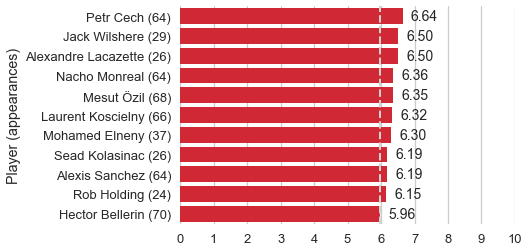

In [8]:
# In matches with SPI ratings, top 11 by normal fan rating
top_df = apps_df.sort_values([('userrating','mean')], ascending=False)
top11_chart(top_df, rating_type='userrating'
           ).get_figure().savefig('../player8project/img/spi-intro/mvp_userrating.png')

3.8197667802610664


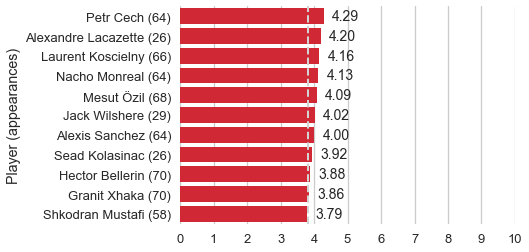

In [9]:
# In matches with SPI ratings, top 11 by adjusted fan rating
top11_chart(adj_top_df, rating_type='adj_userrating'
           ).get_figure().savefig('../player8project/img/spi-intro/mvp_adj_userrating.png')

## Top single-game performances

In [26]:
top_games = spi_df.sort_values(['adj_userrating'], ascending=False)
top11_performances = top_games[['name','date', 'season', 'competition', 'home_away', 'opponent', 
                                'arsegoals','oppgoals', 'userrating', 'adj_userrating']].iloc[0:40]
top11_performances

,name,date,season,competition,home_away,opponent,arsegoals,oppgoals,userrating,adj_userrating
3034,Shkodran Mustafi,2017-11-18,2017-18,Premier League,home,Sp*rs,2.0,0.0,9.5,8.0085
2374,David Ospina,2016-09-13,2016-17,Champions League,away,PSG,1.0,1.0,9.0,7.6185
181,Laurent Koscielny,2017-11-18,2017-18,Premier League,home,Sp*rs,2.0,0.0,9.0,7.5870
1098,Mesut Özil,2017-11-18,2017-18,Premier League,home,Sp*rs,2.0,0.0,9.0,7.5870
1991,Alexis Sanchez,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.2990
1054,Mesut Özil,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.2990
138,Laurent Koscielny,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.2990
2171,Hector Bellerin,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.2990
2997,Shkodran Mustafi,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.2990
723,Theo Walcott,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.2990


In [25]:
top11_performances.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>name</th>\n      <th>date</th>\n      <th>season</th>\n      <th>competition</th>\n      <th>home_away</th>\n      <th>opponent</th>\n      <th>arsegoals</th>\n      <th>oppgoals</th>\n      <th>userrating</th>\n      <th>adj_userrating</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>3034</th>\n      <td>Shkodran Mustafi</td>\n      <td>2017-11-18</td>\n      <td>2017-18</td>\n      <td>Premier League</td>\n      <td>home</td>\n      <td>Sp*rs</td>\n      <td>2.0</td>\n      <td>0.0</td>\n      <td>9.5</td>\n      <td>8.0085</td>\n    </tr>\n    <tr>\n      <th>2374</th>\n      <td>David Ospina</td>\n      <td>2016-09-13</td>\n      <td>2016-17</td>\n      <td>Champions League</td>\n      <td>away</td>\n      <td>PSG</td>\n      <td>1.0</td>\n      <td>1.0</td>\n      <td>9.0</td>\n      <td>7.6185</td>\n    </tr>\n    <tr>\n      <th>181</th>\n      <td>Laurent

In [14]:
spi_df.sort_values(['userrating'], ascending=False)[['name','date', 'season', 'competition', 'home_away', 'opponent', 
                                'arsegoals','oppgoals', 'userrating', 'adj_userrating']]

,name,date,season,competition,home_away,opponent,arsegoals,oppgoals,userrating,adj_userrating
1058,Mesut Özil,2016-10-19,2016-17,Champions League,home,Ludogorets,6.0,0.0,9.5,4.68920
3034,Shkodran Mustafi,2017-11-18,2017-18,Premier League,home,Sp*rs,2.0,0.0,9.5,8.00850
1099,Mesut Özil,2017-11-29,2017-18,Premier League,home,Huddersfield,5.0,0.0,9.5,4.43555
2002,Alexis Sanchez,2016-12-03,2016-17,Premier League,away,West Ham,5.0,1.0,9.5,5.81020
3207,Henrikh Mkhitaryan,2018-02-03,2017-18,Premier League,home,Everton,5.0,1.0,9.5,5.42070
1061,Mesut Özil,2016-11-01,2016-17,Champions League,away,Ludogorets,3.0,2.0,9.0,4.29390
1991,Alexis Sanchez,2016-09-24,2016-17,Premier League,home,Chelsea,3.0,0.0,9.0,7.29900
476,Jack Wilshere,2017-12-07,2017-18,Europa League,home,BATE Borisov,6.0,0.0,9.0,3.91410
1997,Alexis Sanchez,2016-10-29,2016-17,Premier League,away,Sunderland,4.0,1.0,9.0,4.55310
1290,Olivier Giroud,2017-01-01,2016-17,Premier League,home,Crystal Palace,2.0,0.0,9.0,5.34600
